In [11]:
import numpy as np # Version 1.16.0

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import keras # Version 2.2.4
from sklearn.metrics import r2_score
import innvestigate as inn # Version 1.0.8
print("tensorflow version:", tf.__version__)
print("keras version:", keras.__version__)

tensorflow version: 2.13.0
keras version: 2.13.1


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.cluster.hierarchy import linkage, leaves_list
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# tf.compat.v1.disable_eager_execution()  # For innvestigate compatibility if needed

# -------------------------------------------------------------
# LOADING AND PREPARING DATA
# -------------------------------------------------------------
def load_cleaned_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Loaded data from {filepath} with shape {df.shape}")
    # Remove rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]
    return df

# Specify your target columns (already defined)
target_columns = [
    "Digester", "Source", "Type", "Waste", "Biomass", 
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km",
    "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks"
]

df = load_cleaned_data('Data/df_1.csv')

# Split the DataFrame into features (X) and targets (y)
X = df.drop(columns=target_columns)  # OTU/ASV features
y = df[target_columns].apply(pd.to_numeric, errors='coerce')

print(f"Features (X): {X.shape}")
print(f"Targets (y): {y.shape}")

num_samples = X.shape[0]
num_folds = 5
num_features = 500  # number of features to select from LRP or just a chosen subset
chunks = np.ceil(np.linspace(0,num_samples, num=num_folds+1)).astype(int)

# -------------------------------------------------------------
# PREPROCESSING AND ARRANGING FEATURES FOR CNN
# -------------------------------------------------------------
# 1. Feature Selection (Optional): If you want to reduce features before CNN,
#    you can select top features based on variance or another criterion.
if X.shape[1] > num_features:
    # For demonstration, select top `num_features` by variance or mean abundance
    feature_variances = X.var().sort_values(ascending=False)
    top_features = feature_variances.index[:num_features]
    X = X[top_features]

# 2. Compute correlation matrix and cluster features
corr = X.corr().fillna(0)
# Perform hierarchical clustering on correlation
Z = linkage(1 - corr, method='average')  # Using 1 - corr as a distance metric
leaf_order = leaves_list(Z)  # Order of columns (features) after clustering

# Reorder X columns based on cluster order
X = X.iloc[:, leaf_order]

# 3. Reshape features into a 2D grid
# For CNN, we need a 2D (height x width) structure.
# We'll try to form a square grid if possible.
num_features_final = X.shape[1]
grid_size = int(np.ceil(np.sqrt(num_features_final)))  # e.g., if we have 500 features, sqrt(500) ~ 22.36, so 23x23 grid
padding = grid_size**2 - num_features_final

# Pad columns with zeros if needed
if padding > 0:
    extra_cols = pd.DataFrame(0, index=X.index, columns=[f"pad_{i}" for i in range(padding)])
    X = pd.concat([X, extra_cols], axis=1)

# After padding, reshape each sample into a (grid_size, grid_size, 1) "image"
# We'll do this inside the cross-validation loop.

# -------------------------------------------------------------
# DEFINE CNN MODEL
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    # A simple CNN model for regression
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # Assuming you want to predict a single target column at a time;
    # If multiple targets, change units to number of targets.
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


# -------------------------------------------------------------
# CROSS-VALIDATION AND TRAINING CNN
# -------------------------------------------------------------
# We'll pick one target column (e.g., 'ACE-km') for demonstration.
target_column = 'ACE-km'
if target_column not in y.columns:
    raise ValueError(f"Target column {target_column} not found in y.")

all_y_true = []
all_y_pred = []

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

X_values = X.values
y_values = y[target_column].values.astype(float)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_values[train_idx], y_values[val_idx]

    # Reshape data into 2D grid
    X_train = X_train.reshape(X_train.shape[0], grid_size, grid_size, 1)
    X_val = X_val.reshape(X_val.shape[0], grid_size, grid_size, 1)

    # Build and train CNN model
    model = build_cnn_model((grid_size, grid_size, 1))
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

    # Predict
    preds = model.predict(X_val).flatten()
    all_y_true.extend(y_val)
    all_y_pred.extend(preds)

# Evaluate Performance
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

r2 = r2_score(all_y_true, all_y_pred)
mse = mean_squared_error(all_y_true, all_y_pred)
print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_60065/3142300851.py:59: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')  # Using 1 - corr as a distance metric


Loaded data from Data/df_1.csv with shape (60, 1099)
Features (X): (54, 1087)
Targets (y): (54, 12)


NotImplementedError: numpy() is only available when eager execution is enabled.

## With LRP (Different LRP Implementation)

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.cluster.hierarchy import linkage, leaves_list
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy optimizer for M1/M2 Macs
import innvestigate  # For LRP

# -------------------------------------------------------------
# DISABLE EAGER EXECUTION
# -------------------------------------------------------------
tf.compat.v1.disable_eager_execution()

# -------------------------------------------------------------
# LOADING AND PREPARING DATA
# -------------------------------------------------------------
def load_cleaned_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Loaded data from {filepath} with shape {df.shape}")
    # Remove rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]
    return df

target_columns = [
    "Digester", "Source", "Type", "Waste", "Biomass", 
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km",
    "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks"
]

df = load_cleaned_data('Data/df_1.csv')
X = df.drop(columns=target_columns)
y = df[target_columns].apply(pd.to_numeric, errors='coerce')

# Feature Preprocessing
num_features = 500
if X.shape[1] > num_features:
    feature_variances = X.var().sort_values(ascending=False)
    top_features = feature_variances.index[:num_features]
    X = X[top_features]

corr = X.corr().fillna(0)
Z = linkage(1 - corr, method='average')
leaf_order = leaves_list(Z)
X = X.iloc[:, leaf_order]

num_features_final = X.shape[1]
grid_size = int(np.ceil(np.sqrt(num_features_final)))
padding = grid_size**2 - num_features_final
if padding > 0:
    extra_cols = pd.DataFrame(0, index=X.index, columns=[f"pad_{i}" for i in range(padding)])
    X = pd.concat([X, extra_cols], axis=1)

# -------------------------------------------------------------
# DEFINE CNN MODEL
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# -------------------------------------------------------------
# CROSS-VALIDATION WITH LRP
# -------------------------------------------------------------
target_column = 'ACE-km'
all_y_true, all_y_pred = [], []
lrp_cache = pd.DataFrame(index=X.columns)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_values = X.values
y_values = y[target_column].values.astype(float)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_values[train_idx], y_values[val_idx]

    X_train = X_train.reshape(X_train.shape[0], grid_size, grid_size, 1)
    X_val = X_val.reshape(X_val.shape[0], grid_size, grid_size, 1)

    model = build_cnn_model((grid_size, grid_size, 1))
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_val, y_val))

    preds = model.predict(X_val).flatten()
    all_y_true.extend(y_val)
    all_y_pred.extend(preds)

    # Apply LRP
    analyzer = innvestigate.create_analyzer("lrp.z", model)

    # Ensure the input shape for LRP matches the model's input
    relevance_scores = analyzer.analyze(X_train).mean(axis=0)
    relevance_df = pd.DataFrame(relevance_scores.flatten(), index=X.columns, columns=[f"Fold_{fold}"])
    lrp_cache = pd.concat([lrp_cache, relevance_df], axis=1)

# -------------------------------------------------------------
# EVALUATE PERFORMANCE
# -------------------------------------------------------------
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

r2 = r2_score(all_y_true, all_y_pred)
mse = mean_squared_error(all_y_true, all_y_pred)
print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# -------------------------------------------------------------
# LRP RESULTS
# -------------------------------------------------------------
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)
lrp_cache = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

print("\nTop 10 Features by Relevance:")
print(lrp_cache.head(10))

lrp_cache.to_csv("lrp_feature_relevance.csv")


Loaded data from Data/df_1.csv with shape (60, 1099)
Train on 43 samples, validate on 11 samples
Epoch 1/30


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_60134/3076364491.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')
2024-12-16 15:29:21.683865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 15:29:21.683882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-16 15:29:21.694195: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-12-16 15:29:21.698857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_r

32/43 [=====================>........] - ETA: 0s - loss: 328.6580

2024-12-16 15:29:21.782307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 9ms/sample - loss: 327.3038 - val_loss: 105.0337
Epoch 2/30
43/43 [==============================] - 0s 833us/sample - loss: 266.0707 - val_loss: 66.9466
Epoch 3/30
43/43 [==============================] - 0s 406us/sample - loss: 194.8380 - val_loss: 47.7080
Epoch 4/30
43/43 [==============================] - 0s 404us/sample - loss: 120.0106 - val_loss: 104.1501
Epoch 5/30
43/43 [==============================] - 0s 435us/sample - loss: 117.5736 - val_loss: 168.2933
Epoch 6/30
43/43 [==============================] - 0s 416us/sample - loss: 139.8943 - val_loss: 129.9536
Epoch 7/30
43/43 [==============================] - 0s 435us/sample - loss: 111.9772 - val_loss: 77.5818
Epoch 8/30
43/43 [==============================] - 0s 396us/sample - loss: 85.3044 - val_loss: 51.5491
Epoch 9/30


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 15:29:22.019215: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:225 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_27_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:22.028210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 473us/sample - loss: 78.9780 - val_loss: 42.9581
Epoch 10/30
43/43 [==============================] - 0s 410us/sample - loss: 77.3628 - val_loss: 40.4810
Epoch 11/30
43/43 [==============================] - 0s 424us/sample - loss: 72.5615 - val_loss: 39.5274
Epoch 12/30
43/43 [==============================] - 0s 407us/sample - loss: 62.4837 - val_loss: 39.1985
Epoch 13/30
43/43 [==============================] - 0s 1ms/sample - loss: 52.0518 - val_loss: 39.6813
Epoch 14/30
43/43 [==============================] - 0s 429us/sample - loss: 46.5150 - val_loss: 40.4851
Epoch 15/30
43/43 [==============================] - 0s 401us/sample - loss: 42.2993 - val_loss: 39.2432
Epoch 16/30
43/43 [==============================] - 0s 405us/sample - loss: 39.6692 - val_loss: 36.1157
Epoch 17/30
43/43 [==============================] - 0s 419us/sample - loss: 36.2625 - val_loss: 33.2448
Epoch 18/30
43/43 [==============================] - 0s 417us/sample 

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 15:29:22.688627: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_27/BiasAdd' id:207 op device:{requested: '', assigned: ''} def:{{{node dense_27/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_27/MatMul, dense_27/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:22.695407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:22.784743: I te

Train on 43 samples, validate on 11 samples
Epoch 1/30


2024-12-16 15:29:23.697168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:23.711709: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/conv2d_107/bias/m/Assign' id:964 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv2d_107/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv2d_107/bias/m, training_2/Adam/conv2d_107/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:23.725182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:23.766756: I tensorflow/core/grappler/optimizers/custom_g

43/43 [==============================] - 0s 8ms/sample - loss: 270.8602 - val_loss: 263.7934
Epoch 2/30
43/43 [==============================] - 0s 462us/sample - loss: 203.3228 - val_loss: 158.6929
Epoch 3/30
43/43 [==============================] - 0s 450us/sample - loss: 139.5658 - val_loss: 80.8623
Epoch 4/30
43/43 [==============================] - 0s 548us/sample - loss: 104.8754 - val_loss: 72.3702
Epoch 5/30
43/43 [==============================] - 0s 430us/sample - loss: 117.5472 - val_loss: 62.1872
Epoch 6/30
43/43 [==============================] - 0s 441us/sample - loss: 103.7891 - val_loss: 47.7965
Epoch 7/30
43/43 [==============================] - 0s 431us/sample - loss: 81.7627 - val_loss: 41.0160
Epoch 8/30
43/43 [==============================] - 0s 414us/sample - loss: 74.6996 - val_loss: 35.2857
Epoch 9/30


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 15:29:23.979193: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:828 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_29_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:23.993379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 595us/sample - loss: 66.5511 - val_loss: 25.7481
Epoch 10/30
43/43 [==============================] - 0s 455us/sample - loss: 57.7824 - val_loss: 19.5270
Epoch 11/30
43/43 [==============================] - 0s 431us/sample - loss: 50.9655 - val_loss: 19.2029
Epoch 12/30
43/43 [==============================] - 0s 555us/sample - loss: 42.8403 - val_loss: 23.6055
Epoch 13/30
43/43 [==============================] - 0s 453us/sample - loss: 38.6877 - val_loss: 33.6222
Epoch 14/30
43/43 [==============================] - 0s 451us/sample - loss: 34.6027 - val_loss: 42.5469
Epoch 15/30
43/43 [==============================] - 0s 424us/sample - loss: 30.5487 - val_loss: 46.1987
Epoch 16/30
43/43 [==============================] - 0s 1ms/sample - loss: 27.1690 - val_loss: 47.6960
Epoch 17/30
43/43 [==============================] - 0s 434us/sample - loss: 25.8007 - val_loss: 50.8763
Epoch 18/30
43/43 [==============================] - 0s 436us/sample 

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 15:29:24.626550: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_29/BiasAdd' id:810 op device:{requested: '', assigned: ''} def:{{{node dense_29/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_29/MatMul, dense_29/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:24.639806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:24.707508: I te

Train on 43 samples, validate on 11 samples
Epoch 1/30


2024-12-16 15:29:25.315639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:25.331306: W tensorflow/c/c_api.cc:304] Operation '{name:'training_4/Adam/conv2d_109/kernel/v/Assign' id:1596 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/conv2d_109/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/conv2d_109/kernel/v, training_4/Adam/conv2d_109/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:25.349950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:25.393673: I tensorflow/core/grappler/optimizers

43/43 [==============================] - 0s 9ms/sample - loss: 279.4959 - val_loss: 266.6295
Epoch 2/30
43/43 [==============================] - 0s 423us/sample - loss: 210.5407 - val_loss: 197.5978
Epoch 3/30
43/43 [==============================] - 0s 436us/sample - loss: 146.9265 - val_loss: 143.3548
Epoch 4/30
43/43 [==============================] - 0s 494us/sample - loss: 97.2554 - val_loss: 146.6370
Epoch 5/30
43/43 [==============================] - 0s 444us/sample - loss: 111.3286 - val_loss: 146.7115
Epoch 6/30
43/43 [==============================] - 0s 430us/sample - loss: 101.3102 - val_loss: 123.1078
Epoch 7/30
43/43 [==============================] - 0s 428us/sample - loss: 74.2368 - val_loss: 114.6763
Epoch 8/30
43/43 [==============================] - 0s 426us/sample - loss: 59.8773 - val_loss: 115.3274
Epoch 9/30


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 15:29:25.600569: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_2/mul' id:1421 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_31_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:25.618236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 1ms/sample - loss: 56.7330 - val_loss: 114.5698
Epoch 10/30
43/43 [==============================] - 0s 480us/sample - loss: 52.7060 - val_loss: 110.2498
Epoch 11/30
43/43 [==============================] - 0s 420us/sample - loss: 44.7934 - val_loss: 101.0013
Epoch 12/30
43/43 [==============================] - 0s 412us/sample - loss: 35.8617 - val_loss: 88.8064
Epoch 13/30
43/43 [==============================] - 0s 441us/sample - loss: 30.6524 - val_loss: 78.9447
Epoch 14/30
43/43 [==============================] - 0s 427us/sample - loss: 27.8535 - val_loss: 73.0615
Epoch 15/30
43/43 [==============================] - 0s 425us/sample - loss: 27.4476 - val_loss: 69.7461
Epoch 16/30
43/43 [==============================] - 0s 443us/sample - loss: 26.0790 - val_loss: 68.9438
Epoch 17/30
43/43 [==============================] - 0s 418us/sample - loss: 23.7738 - val_loss: 70.9207
Epoch 18/30
43/43 [==============================] - 0s 410us/samp

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 15:29:26.245811: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_31/BiasAdd' id:1403 op device:{requested: '', assigned: ''} def:{{{node dense_31/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_31/MatMul, dense_31/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:26.267658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:26.345919: I t

Train on 43 samples, validate on 11 samples
Epoch 1/30


2024-12-16 15:29:26.876747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:27.096595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:27.114487: W tensorflow/c/c_api.cc:304] Operation '{name:'training_6/Adam/dense_33/kernel/v/Assign' id:2211 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_33/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_33/kernel/v, training_6/Adam/dense_33/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:27.139758: I tensorflow/core/grappler/optimizers/custom_

43/43 [==============================] - 0s 9ms/sample - loss: 288.1921 - val_loss: 214.9102
Epoch 2/30
43/43 [==============================] - 0s 1ms/sample - loss: 216.0512 - val_loss: 147.8394
Epoch 3/30
43/43 [==============================] - 0s 592us/sample - loss: 138.9318 - val_loss: 94.8368
Epoch 4/30
43/43 [==============================] - 0s 718us/sample - loss: 108.7391 - val_loss: 94.5317
Epoch 5/30
43/43 [==============================] - 0s 490us/sample - loss: 120.6458 - val_loss: 89.3727
Epoch 6/30


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 15:29:27.381116: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_3/mul' id:2014 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_33_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:27.410897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 0s 608us/sample - loss: 102.6308 - val_loss: 78.2773
Epoch 7/30
43/43 [==============================] - 0s 491us/sample - loss: 80.1275 - val_loss: 75.6229
Epoch 8/30
43/43 [==============================] - 0s 506us/sample - loss: 69.9354 - val_loss: 76.4184
Epoch 9/30
43/43 [==============================] - 0s 473us/sample - loss: 67.2325 - val_loss: 73.5945
Epoch 10/30
43/43 [==============================] - 0s 460us/sample - loss: 61.0636 - val_loss: 66.0988
Epoch 11/30
43/43 [==============================] - 0s 487us/sample - loss: 49.9986 - val_loss: 59.9577
Epoch 12/30
43/43 [==============================] - 0s 596us/sample - loss: 43.4388 - val_loss: 61.0380
Epoch 13/30
43/43 [==============================] - 0s 547us/sample - loss: 43.1401 - val_loss: 66.3070
Epoch 14/30
43/43 [==============================] - 0s 459us/sample - loss: 43.6894 - val_loss: 65.3627
Epoch 15/30
43/43 [==============================] - 0s 558us/sample 

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 15:29:28.145488: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_33/BiasAdd' id:1996 op device:{requested: '', assigned: ''} def:{{{node dense_33/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_33/MatMul, dense_33/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:28.170116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:28.247298: I t

Train on 44 samples, validate on 10 samples
Epoch 1/30


2024-12-16 15:29:29.148032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:29.181790: W tensorflow/c/c_api.cc:304] Operation '{name:'training_8/Adam/dense_35/bias/m/Assign' id:2765 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_35/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_35/bias/m, training_8/Adam/dense_35/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:29.208949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:29.249805: I tensorflow/core/grappler/optimizers/custom_graph_op

44/44 [==============================] - 0s 9ms/sample - loss: 268.9668 - val_loss: 269.3133
Epoch 2/30
44/44 [==============================] - 0s 464us/sample - loss: 188.6045 - val_loss: 164.8942
Epoch 3/30
44/44 [==============================] - 0s 483us/sample - loss: 120.5864 - val_loss: 111.8714
Epoch 4/30
44/44 [==============================] - 0s 542us/sample - loss: 86.2249 - val_loss: 137.5443
Epoch 5/30
44/44 [==============================] - 0s 466us/sample - loss: 110.4752 - val_loss: 114.9531
Epoch 6/30
44/44 [==============================] - 0s 414us/sample - loss: 92.2179 - val_loss: 78.2149
Epoch 7/30
32/44 [====================>.........] - ETA: 0s - loss: 73.5714

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 15:29:29.449313: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_4/mul' id:2607 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_35_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:29.480519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 0s 450us/sample - loss: 64.4746 - val_loss: 66.1532
Epoch 8/30
44/44 [==============================] - 0s 442us/sample - loss: 57.9322 - val_loss: 66.3100
Epoch 9/30
44/44 [==============================] - 0s 439us/sample - loss: 58.6591 - val_loss: 60.2678
Epoch 10/30
44/44 [==============================] - 0s 469us/sample - loss: 55.7113 - val_loss: 45.6454
Epoch 11/30
44/44 [==============================] - 0s 423us/sample - loss: 46.3753 - val_loss: 30.7102
Epoch 12/30
44/44 [==============================] - 0s 414us/sample - loss: 38.5723 - val_loss: 22.1849
Epoch 13/30
44/44 [==============================] - 0s 1ms/sample - loss: 35.4529 - val_loss: 23.0783
Epoch 14/30
44/44 [==============================] - 0s 399us/sample - loss: 38.5625 - val_loss: 24.4403
Epoch 15/30
44/44 [==============================] - 0s 463us/sample - loss: 39.5965 - val_loss: 18.7293
Epoch 16/30
44/44 [==============================] - 0s 425us/sample - 

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 15:29:30.124381: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_35/BiasAdd' id:2589 op device:{requested: '', assigned: ''} def:{{{node dense_35/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_35/MatMul, dense_35/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 15:29:30.153838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 15:29:30.236904: I t

R2 Score: 0.6567
MSE: 35.4466

Top 10 Features by Relevance:
                                                      Fold_0    Fold_1  \
d__Bacteria;p__Patescibacteria;c__ABY1;o__Candi...  0.218976  0.309958   
d__Bacteria;p__Bdellovibrionota;c__Oligoflexia;...  0.184825  0.290532   
d__Bacteria;p__Desulfobacterota;c__Syntrophobac...  0.228910  0.189231   
d__Bacteria;p__Proteobacteria;c__Gammaproteobac...  0.127278  0.236007   
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;...  0.157463  0.198628   
d__Bacteria;p__Planctomycetota;c__Phycisphaerae...  0.141624  0.178766   
d__Archaea;p__Euryarchaeota;c__Thermococci;o__M...  0.179691  0.182948   
d__Bacteria;p__Planctomycetota;c__Phycisphaerae...  0.146925  0.136751   
d__Bacteria;p__Firmicutes;c__Bacilli;o__Izemopl...  0.139216  0.115580   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...  0.185119  0.189965   

                                                      Fold_2    Fold_3  \
d__Bacteria;p__Patescibacteria;c__ABY1;o__Candi...

## LRP and Feature Selection

/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_60134/860659427.py:36: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')  # Perform hierarchical clustering
2024-12-16 16:10:42.452231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 16:10:42.452250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-16 16:10:42.459385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 16:10:42.472015: W tens


Cross Validation Results:

Neural Network R2 Score: 0.40685
Mean Squared Error: 61.24905

Top 10 Features by Relevance:
                                                      Fold_0    Fold_1  \
d__Bacteria;p__Patescibacteria;c__ABY1;o__Candi...  0.366577  0.276790   
d__Bacteria;p__Planctomycetota;c__Phycisphaerae...  0.261308  0.354189   
d__Bacteria;p__Planctomycetota;c__Pla4_lineage;...  0.231701  0.320676   
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__...  0.173428  0.203659   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...  0.180622  0.183965   
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;...  0.209367  0.197617   
d__Bacteria;p__Desulfobacterota;c__Syntrophorha...  0.095076  0.120176   
d__Bacteria;p__MBNT15;c__MBNT15;o__MBNT15;f__MB...  0.148831  0.164191   
d__Bacteria;p__Synergistota;c__Synergistia;o__S...  0.166302  0.167118   
d__Bacteria;p__Proteobacteria;c__Alphaproteobac...  0.166009  0.224010   

                                                      Fold_2    

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-16 16:10:57.473277: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/BiasAdd' id:101 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 16:10:57.479125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


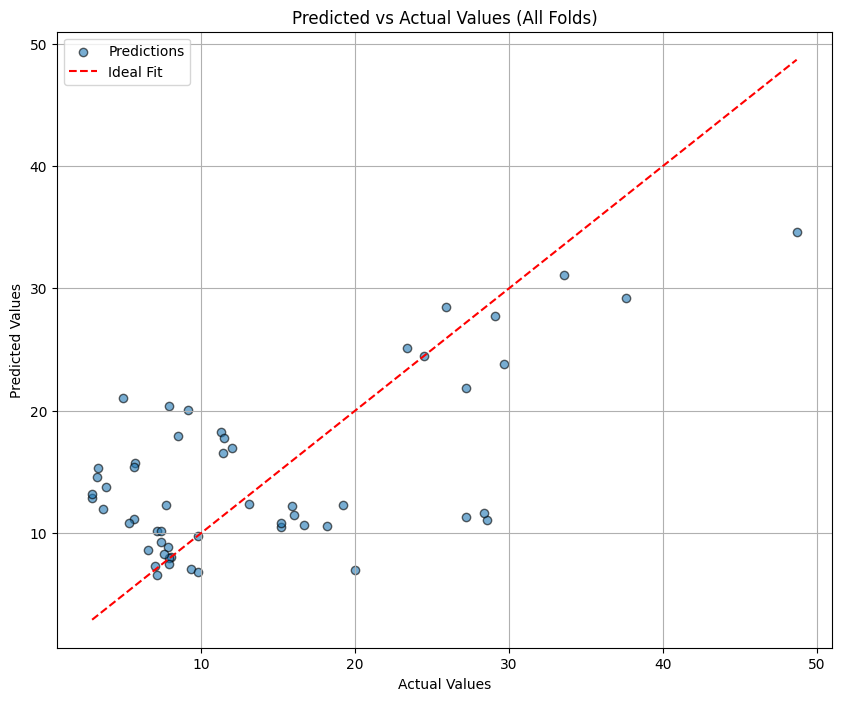

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.cluster.hierarchy import linkage, leaves_list
import innvestigate


# -------------------------------------------------------------
# DEFINE CNN MODEL FUNCTION
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### Run Neural Network Cross Validation
lrp_cache = pd.DataFrame()
ann_predictions = np.array([])
ann_actuals = np.array([])  # To store actual values for plotting
history_cache = []

# Convert boolean columns to integers (if not already done)
X = X.astype({col: 'int32' for col in X.select_dtypes('bool').columns})

# Specify the target column for single-output regression
target_column = 'ACE-km'  # Replace with your target column name

# -------------------------------------------------------------
# FEATURE SELECTION AND HIERARCHICAL CLUSTERING
# -------------------------------------------------------------
# Select top `num_features` based on variance
num_features = 400  # Change as needed
if X.shape[1] > num_features:
    feature_variances = X.var().sort_values(ascending=False)
    top_features = feature_variances.index[:num_features]
    X = X[top_features]

# Hierarchical clustering to reorder features
corr = X.corr().fillna(0)  # Compute correlation matrix
Z = linkage(1 - corr, method='average')  # Perform hierarchical clustering
leaf_order = leaves_list(Z)  # Get feature order based on clustering
X = X.iloc[:, leaf_order]  # Reorder features based on clustering

# -------------------------------------------------------------
# PREPROCESSING
# -------------------------------------------------------------
# Pad features to form a square grid for potential 2D inputs
num_features_final = X.shape[1]
grid_size = int(np.ceil(np.sqrt(num_features_final)))  # Determine grid size
padding = grid_size**2 - num_features_final  # Calculate necessary padding

# Add padding columns with zeros if required
if padding > 0:
    extra_cols = pd.DataFrame(0, index=X.index, columns=[f"pad_{i}" for i in range(padding)])
    X = pd.concat([X, extra_cols], axis=1)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)  # Convert to numpy array after scaling

# -------------------------------------------------------------
# CROSS-VALIDATION WITH LRP
# -------------------------------------------------------------
for fold in range(num_folds):

    # Reset keras session to reduce model clutter
    tf.keras.backend.clear_session()

    # Define train-test splits
    X_val = X_scaled[chunks[fold]:chunks[fold + 1]]
    y_val = y[chunks[fold]:chunks[fold + 1]][target_column]

    X_train = np.delete(X_scaled, np.arange(chunks[fold], chunks[fold + 1]), axis=0)
    y_train = y.drop(y_val.index)[target_column]

    # Ensure target values are numeric and have the correct shape
    y_train = y_train.astype(float).values
    y_val = y_val.astype(float).values

    # Reshape data for neural network input
    X_train = X_train.reshape(X_train.shape[0], grid_size, grid_size, 1)  # Add channel dimension
    X_val = X_val.reshape(X_val.shape[0], grid_size, grid_size, 1)  # Add channel dimension

    # Build and train the neural network model
    model = build_cnn_model((grid_size, grid_size, 1))
    model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=0, validation_data=(X_val, y_val))

    # Apply LRP
    analyzer = innvestigate.create_analyzer("lrp.z_plus_fast", model)
    relevance_scores = analyzer.analyze(X_train)  # Analyze training data

    # Flatten relevance scores and trim to original feature dimensions
    relevance_scores_flat = relevance_scores.mean(axis=0).flatten()[:num_features_final]

    # Store LRP results for original features only
    lrp = pd.DataFrame(relevance_scores_flat, index=X.columns[:num_features_final], columns=[f"Fold_{fold}"])
    lrp_cache = pd.concat([lrp_cache, lrp], axis=1)

    # Predict and store validation results
    predictions = model.predict(X_val).flatten()
    ann_predictions = np.concatenate([ann_predictions, predictions])
    ann_actuals = np.concatenate([ann_actuals, y_val])  # Store actual values for plotting
    history_cache.append(model.history)

# -------------------------------------------------------------
# EVALUATE MODEL PERFORMANCE
# -------------------------------------------------------------
ann_r2 = r2_score(ann_actuals, ann_predictions)  # R² for regression
ann_mse = mean_squared_error(ann_actuals, ann_predictions)  # MSE for regression

print("\nCross Validation Results:\n")
print("Neural Network R2 Score: {:.5f}".format(ann_r2))
print("Mean Squared Error: {:.5f}".format(ann_mse))

# -------------------------------------------------------------
# SAVE LRP RESULTS
# -------------------------------------------------------------
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)
lrp_cache = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

print("\nTop 10 Features by Relevance:")
print(lrp_cache.head(10))

lrp_cache.to_csv("lrp_feature_relevance.csv")

# -------------------------------------------------------------
# PLOT PREDICTED VS ACTUAL VALUES
# -------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(ann_actuals, ann_predictions, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([ann_actuals.min(), ann_actuals.max()],
         [ann_actuals.min(), ann_actuals.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (All Folds)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.savefig("predicted_vs_actual_plot.png")
plt.show()




## Feature Processing + LRP + LOGO

In [46]:
# -------------------------------------------------------------
# LOADING AND PREPARING DATA
# -------------------------------------------------------------
def load_cleaned_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Loaded data from {filepath} with shape {df.shape}")
    # Remove rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]
    return df

# Specify your target columns (already defined)
target_columns = [
    "Digester", "Source", "Type", "Waste", "Biomass", 
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km",
    "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks"
]

df = load_cleaned_data('Data/df_1.csv')

# Split the DataFrame into features (X) and targets (y)
X = df.drop(columns=target_columns)  # OTU/ASV features
y = df[target_columns].apply(pd.to_numeric, errors='coerce')

Loaded data from Data/df_1.csv with shape (60, 1099)


Loaded data from Data/df_1.csv with shape (60, 1099)
Processing Fold 1


/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_2116/3613053180.py:78: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - corr, method='average')  # Perform hierarchical clustering
2024-12-16 19:46:33.801375: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-16 19:46:33.801446: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-16 19:46:33.801457: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-16 19:46:33.801495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 19:46:33.801513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/

Processing Fold 2


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:46:36.869222: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:696 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:36.878890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:38.741232: I tensorflow/core/grappler/optimizers/custom_gra

Processing Fold 3


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:46:39.623724: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_2/mul' id:1273 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:39.639125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:41.564222: I tensorflow/core/grappler/optimizers/custom_gr

Processing Fold 4


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:46:42.582587: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_3/mul' id:1850 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:42.602036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:44.510356: I tensorflow/core/grappler/optimizers/custom_gr

Processing Fold 5


2024-12-16 19:46:45.409292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:45.425434: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_9/kernel/Assign' id:2349 op device:{requested: '', assigned: ''} def:{{{node conv2d_9/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_9/kernel, conv2d_9/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:45.449601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:45.482371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for

Processing Fold 6


2024-12-16 19:46:48.734968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:46:48.913986: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_5/mul' id:3004 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/dense_11_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:48.943690: I tensorflow/core/grappler/optimizers/custom_g

Processing Fold 7


2024-12-16 19:46:52.212962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:52.232959: W tensorflow/c/c_api.cc:304] Operation '{name:'training_12/Adam/dense_13/bias/v/Assign' id:3783 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_13/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_13/bias/v, training_12/Adam/dense_13/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:52.269294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:52.307734: I tensorflow/core/grappler/optimizers/custom_grap

Processing Fold 8


2024-12-16 19:46:55.947127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:55.984834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:46:56.167757: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_7/mul' id:4158 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_15_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in t

Processing Fold 9


2024-12-16 19:46:59.656965: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_17/kernel/Assign' id:4657 op device:{requested: '', assigned: ''} def:{{{node conv2d_17/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_17/kernel, conv2d_17/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:46:59.702709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:46:59.741761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Mode

Processing Fold 10


2024-12-16 19:47:03.573789: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_19/bias/Assign' id:5239 op device:{requested: '', assigned: ''} def:{{{node conv2d_19/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_19/bias, conv2d_19/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:03.626250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:03.667732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be re

Processing Fold 11


2024-12-16 19:47:07.703030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:07.724184: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_20/bias/Assign' id:5792 op device:{requested: '', assigned: ''} def:{{{node conv2d_20/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_20/bias, conv2d_20/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:07.781446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:07.824479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is ena

Processing Fold 12


2024-12-16 19:47:11.968416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:11.992530: W tensorflow/c/c_api.cc:304] Operation '{name:'training_22/Adam/dense_22/kernel/m/Assign' id:6609 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_22/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_22/kernel/m, training_22/Adam/dense_22/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:12.055136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:12.099727: I tensorflow/core/grappler/optimizers/cus

Processing Fold 13


2024-12-16 19:47:16.424296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:16.470989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:47:16.675293: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_12/mul' id:7043 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_25_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

Processing Fold 14


2024-12-16 19:47:21.009998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:21.057357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-12-16 19:47:21.246973: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_13/mul' id:7620 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_27_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error 

Processing Fold 15


2024-12-16 19:47:25.686477: W tensorflow/c/c_api.cc:304] Operation '{name:'training_28/Adam/dense_28/bias/m/Assign' id:8345 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_28/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_28/bias/m, training_28/Adam/dense_28/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:25.770138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:25.820351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/e

Processing Fold 16


2024-12-16 19:47:30.582076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:30.607589: W tensorflow/c/c_api.cc:304] Operation '{name:'training_30/Adam/dense_31/bias/m/Assign' id:8932 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_31/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_31/bias/m, training_30/Adam/dense_31/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:30.697178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:30.749665: I tensorflow/core/grappler/optimizers/custom_grap

Processing Fold 17


2024-12-16 19:47:36.013721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:36.039184: W tensorflow/c/c_api.cc:304] Operation '{name:'training_32/Adam/conv2d_32/bias/v/Assign' id:9519 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/conv2d_32/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/conv2d_32/bias/v, training_32/Adam/conv2d_32/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:36.129569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:36.179273: I tensorflow/core/grappler/optimizers/custom_

Processing Fold 18


2024-12-16 19:47:41.383002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:41.409590: W tensorflow/c/c_api.cc:304] Operation '{name:'training_34/Adam/dense_34/bias/m/Assign' id:10076 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_34/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_34/bias/m, training_34/Adam/dense_34/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 19:47:41.504487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 19:47:41.557902: I tensorflow/core/grappler/optimizers/custom_gra


Cross Validation Results:

Neural Network R2 Score: 0.51107
Mean Squared Error: 469.92194

Top 10 Features by Relevance:
                                                      Fold_0    Fold_1  \
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o...  1.554159  1.328153   
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__A...  1.092423  1.036684   
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__A...  1.062176  0.991212   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...  1.007981  0.849540   
d__Bacteria;p__Firmicutes;c__Bacilli;o__Izemopl...  0.994421  0.854609   
d__Bacteria;p__Desulfobacterota;c__Syntrophorha...  0.792234  0.642090   
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;...  0.773683  0.717624   
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o...  0.764324  0.568826   
d__Bacteria;p__Verrucomicrobiota;c__Kiritimatie...  0.873223  0.713939   
d__Archaea;p__Euryarchaeota;c__Methanobacteria;...  0.783095  0.516274   

                                                      Fold_2   

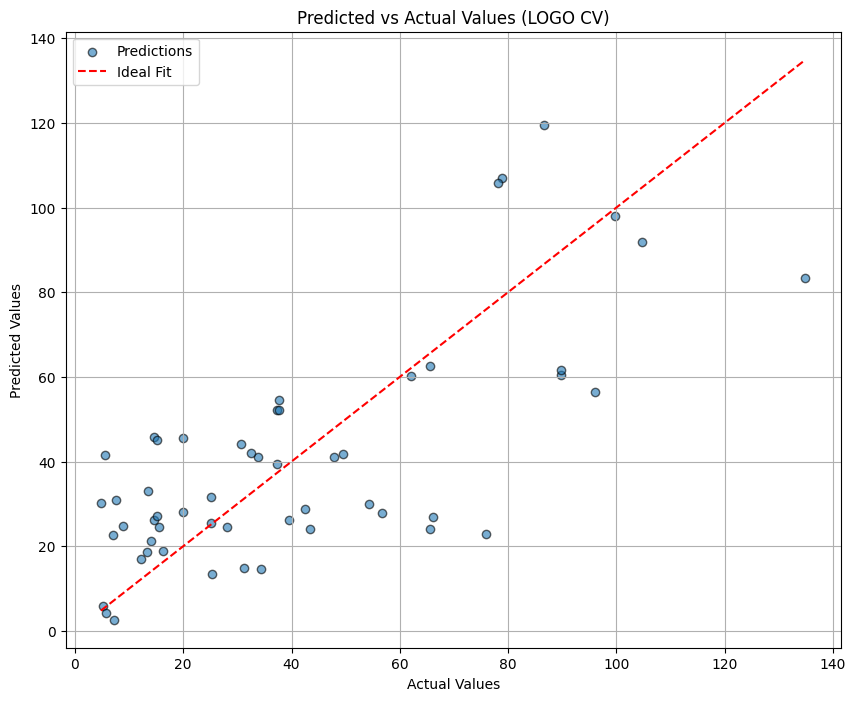


Top 10 Features Based on Mean Absolute Relevance Across All Folds:
                                                      Fold_0    Fold_1  \
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o...  1.554159  1.328153   
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__A...  1.092423  1.036684   
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__A...  1.062176  0.991212   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...  1.007981  0.849540   
d__Bacteria;p__Firmicutes;c__Bacilli;o__Izemopl...  0.994421  0.854609   
d__Bacteria;p__Desulfobacterota;c__Syntrophorha...  0.792234  0.642090   
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;...  0.773683  0.717624   
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o...  0.764324  0.568826   
d__Bacteria;p__Verrucomicrobiota;c__Kiritimatie...  0.873223  0.713939   
d__Archaea;p__Euryarchaeota;c__Methanobacteria;...  0.783095  0.516274   

                                                      Fold_2    Fold_3  \
d__Bacteria;p__Desulfobacterota;c__Syntroph

,Fold_0,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,Fold_11,Fold_12,Fold_13,Fold_14,Fold_15,Fold_16,Fold_17,Mean_Abs_Relevance
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Syntrophaceae;g__Syntrophus,1.554159,1.328153,1.254872,1.479780,1.371503,1.437509,1.362065,1.441241,1.590954,1.152032,1.209959,1.430500,1.361000,1.645676,1.684387,0.952027,1.197814,0.701397,1.341946
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Leptolinea,1.092423,1.036684,1.243518,0.985410,1.332561,0.882941,0.803394,1.214500,1.410754,1.024850,1.237260,1.073619,1.170681,1.210894,1.189901,0.929688,1.051152,0.651712,1.085663
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Anaerolineales;f__Anaerolineaceae;g__Pelolinea,1.062176,0.991212,1.075662,1.078528,1.132908,1.092860,0.747056,1.161088,1.241272,0.957092,1.083467,1.054706,0.993976,1.169106,1.214501,0.808932,0.967132,0.712417,1.030227
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__;__,1.007981,0.849540,0.942687,0.934657,0.836094,1.003040,0.902560,0.957762,1.128799,0.792946,0.871089,0.880855,0.858971,1.081175,0.977510,0.715021,0.849273,0.580879,0.898380
d__Bacteria;p__Firmicutes;c__Bacilli;o__Izemoplasmatales;f__Izemoplasmatales;g__Izemoplasmatales,0.994421,0.854609,0.799151,0.794789,0.839801,1.191159,0.587325,0.736775,0.879845,0.934216,1.052879,0.812541,0.908936,0.853714,1.157695,0.571090,0.847735,0.304525,0.840067
d__Bacteria;p__Desulfobacterota;c__Syntrophorhabdia;o__Syntrophorhabdales;f__Syntrophorhabdaceae;g__Syntrophorhabdus,0.792234,0.642090,0.716941,1.051002,0.826560,0.205881,0.822625,0.624077,0.739724,0.854243,0.674398,0.766956,0.840932,0.934889,0.842499,0.791292,0.855098,0.774828,0.764237
d__Bacteria;p__Cloacimonadota;c__Cloacimonadia;o__Cloacimonadales;f__Cloacimonadaceae;g__LNR_A2-18,0.773683,0.717624,0.721481,0.593476,0.632202,0.940280,0.874549,0.777023,0.928287,0.716816,0.759540,0.812967,0.777953,0.925468,0.932688,0.544567,0.717665,0.323503,0.748321
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Smithellaceae;g__Smithella,0.764324,0.568826,0.754614,0.709681,0.732856,1.000666,0.798069,0.657342,0.794336,0.703348,0.821778,0.786428,0.638631,0.933976,0.871767,0.613555,0.694662,0.486830,0.740649
d__Bacteria;p__Verrucomicrobiota;c__Kiritimatiellae;o__WCHB1-41;f__WCHB1-41;g__WCHB1-41,0.873223,0.713939,0.674357,0.797617,0.831050,1.013480,0.444724,0.596344,0.773930,0.760567,0.843049,0.684442,0.707201,0.764857,0.947738,0.551881,0.663156,0.144855,0.710356
d__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium,0.783095,0.516274,0.693385,0.827591,0.700320,0.812371,0.684028,0.726524,0.557161,0.702028,0.857325,0.633959,0.686233,0.701763,0.830436,0.671864,0.713271,0.316357,0.689666


In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
import innvestigate
from scipy.cluster.hierarchy import linkage, leaves_list

# -------------------------------------------------------------
# LOADING AND PREPARING DATA
# -------------------------------------------------------------
def load_cleaned_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Loaded data from {filepath} with shape {df.shape}")
    # Remove rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]
    return df

# Specify your target columns (already defined)
target_columns = [
    "Digester", "Source", "Type", "Waste", "Biomass", 
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km",
    "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks"
]

df = load_cleaned_data('Data/df_1.csv')

# Split the DataFrame into features (X) and targets (y)
X = df.drop(columns=target_columns)  # OTU/ASV features
y = df[target_columns] # .apply(pd.to_numeric, errors='coerce')

# -------------------------------------------------------------
# DEFINE CNN MODEL FUNCTION
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
    return model

### Initialize LOGO
logo = LeaveOneGroupOut()

### Run Neural Network Cross Validation
lrp_cache = pd.DataFrame()
ann_predictions = np.array([])
ann_actuals = np.array([])  # To store actual values for plotting
history_cache = []

# Convert boolean columns to integers (if not already done)
X = X.astype({col: 'int32' for col in X.select_dtypes('bool').columns})

# Specify the target column for single-output regression
target_column = 'H2-km'  # Replace with your target column name
groups = y['Digester']  # Use Digester as the grouping variable

# -------------------------------------------------------------
# FEATURE SELECTION AND HIERARCHICAL CLUSTERING
# -------------------------------------------------------------
# Select top `num_features` based on variance
num_features = 200  # Change as needed
if X.shape[1] > num_features:
    feature_variances = X.var().sort_values(ascending=False)
    top_features = feature_variances.index[:num_features]
    X = X[top_features]

# Hierarchical clustering to reorder features
corr = X.corr().fillna(0)  # Compute correlation matrix
Z = linkage(1 - corr, method='average')  # Perform hierarchical clustering
leaf_order = leaves_list(Z)  # Get feature order based on clustering
X = X.iloc[:, leaf_order]  # Reorder features based on clustering

# -------------------------------------------------------------
# PREPROCESSING
# -------------------------------------------------------------
# Pad features to form a square grid for potential 2D inputs
num_features_final = X.shape[1]
grid_size = int(np.ceil(np.sqrt(num_features_final)))  # Determine grid size
padding = grid_size**2 - num_features_final  # Calculate necessary padding

# Add padding columns with zeros if required
if padding > 0:
    extra_cols = pd.DataFrame(0, index=X.index, columns=[f"pad_{i}" for i in range(padding)])
    X = pd.concat([X, extra_cols], axis=1)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)  # Convert to numpy array after scaling

# -------------------------------------------------------------
# LOGO CROSS-VALIDATION WITH LRP
# -------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(logo.split(X_scaled, y[target_column], groups=groups)):
    print(f"Processing Fold {fold + 1}")

    # Define train-test splits
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx][target_column], y.iloc[val_idx][target_column]

    # Ensure target values are numeric and have the correct shape
    y_train = y_train.astype(float).values
    y_val = y_val.astype(float).values

    # Reshape data for neural network input
    X_train = X_train.reshape(X_train.shape[0], grid_size, grid_size, 1)  # Add channel dimension
    X_val = X_val.reshape(X_val.shape[0], grid_size, grid_size, 1)  # Add channel dimension

    # Build and train the neural network model
    model = build_cnn_model((grid_size, grid_size, 1))
    model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=0, validation_data=(X_val, y_val))

    # Apply LRP
    analyzer = innvestigate.create_analyzer("lrp.z_plus_fast", model)
    relevance_scores = analyzer.analyze(X_train)  # Analyze training data

    # Flatten relevance scores and trim to original feature dimensions
    relevance_scores_flat = relevance_scores.mean(axis=0).flatten()[:num_features_final]

    # Store LRP results for original features only
    lrp = pd.DataFrame(relevance_scores_flat, index=X.columns[:num_features_final], columns=[f"Fold_{fold}"])
    lrp_cache = pd.concat([lrp_cache, lrp], axis=1)

    # Predict and store validation results
    predictions = model.predict(X_val).flatten()
    ann_predictions = np.concatenate([ann_predictions, predictions])
    ann_actuals = np.concatenate([ann_actuals, y_val])  # Store actual values for plotting
    history_cache.append(model.history)

# -------------------------------------------------------------
# EVALUATE MODEL PERFORMANCE
# -------------------------------------------------------------
ann_r2 = r2_score(ann_actuals, ann_predictions)  # R² for regression
ann_mse = mean_squared_error(ann_actuals, ann_predictions)  # MSE for regression

print("\nCross Validation Results:\n")
print("Neural Network R2 Score: {:.5f}".format(ann_r2))
print("Mean Squared Error: {:.5f}".format(ann_mse))

# -------------------------------------------------------------
# SAVE LRP RESULTS
# -------------------------------------------------------------
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)
lrp_cache = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

print("\nTop 10 Features by Relevance:")
print(lrp_cache.head(10))

lrp_cache.to_csv("lrp_feature_relevance.csv")

# -------------------------------------------------------------
# PLOT PREDICTED VS ACTUAL VALUES
# -------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(ann_actuals, ann_predictions, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([ann_actuals.min(), ann_actuals.max()],
         [ann_actuals.min(), ann_actuals.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (LOGO CV)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.savefig("predicted_vs_actual_plot_logo.png")
plt.show()


# -------------------------------------------------------------
# GENERATE TABLE WITH TOP 10 SELECTED FEATURES
# -------------------------------------------------------------
# Calculate the mean absolute relevance for each feature across all folds
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)

# Sort features by mean absolute relevance
lrp_cache_sorted = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

# Extract the top 10 features
top_10_features = lrp_cache_sorted.head(10)

# Print the table
print("\nTop 10 Features Based on Mean Absolute Relevance Across All Folds:")
print(top_10_features)

# Save the table as a CSV file
top_10_features.to_csv("top_10_features.csv")

# Display the table in a formatted output
from IPython.display import display
display(top_10_features)


## Only LRP

2024-12-16 17:49:48.350183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 17:49:48.350202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-16 17:49:48.380358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 17:49:48.406004: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense/kernel/v/Assign' id:816 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/


Cross Validation Results:

Neural Network R2 Score: -7.13393
Mean Squared Error: 839.91551

Top 10 Features by Relevance:
                                                      Fold_0    Fold_1  \
d__Bacteria;p__Patescibacteria;c__ABY1;o__Candi...  2.909785  0.272193   
d__Bacteria;p__Spirochaetota;c__Leptospirae;o__...  1.077209  0.783674   
d__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...  1.431850  0.643031   
d__Archaea;p__Thermoplasmatota;c__Thermoplasmat...  1.353789  0.443970   
d__Bacteria;p__uncultured;c__uncultured;o__uncu...  1.069619  0.744461   
d__Bacteria;p__Firmicutes;c__Clostridia;o__Chri...  1.296473  0.592079   
d__Bacteria;p__Bacteroidota;c__Kapabacteria;o__...  1.323332  0.072641   
d__Bacteria;p__Verrucomicrobiota;c__Omnitrophia...  1.228497 -0.031841   
d__Bacteria;p__Desulfobacterota;c__Syntrophobac...  0.545164  0.819883   
d__Bacteria;p__Desulfobacterota;c__Syntrophia;o...  1.162561  0.075771   

                                                      Fold_2  

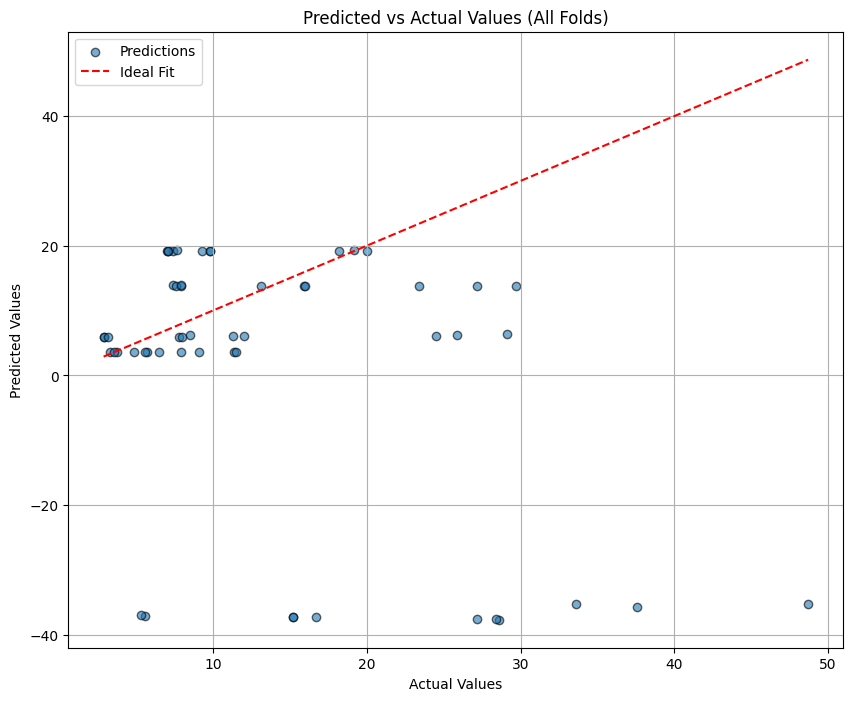

In [ ]:
import tensorflow as tf
# Do not disable eager execution unless absolutely necessary
# tf.compat.v1.disable_eager_execution()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import innvestigate
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# -------------------------------------------------------------
# DEFINE CNN MODEL FUNCTION
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
    return model

### Run Neural Network Cross Validation
lrp_cache = pd.DataFrame()
ann_predictions = np.array([])
ann_actuals = np.array([])  # To store actual values for plotting
history_cache = []

# Specify the target column for single-output regression
target_column = 'ACE-km'  # Replace with your target column name

# -------------------------------------------------------------
# PREPROCESSING
# -------------------------------------------------------------
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)  # Convert to numpy array after scaling

# Add a parameter for the number of features to select after LRP
num_features_after_lrp = 100  # Adjust as needed

# -------------------------------------------------------------
# CROSS-VALIDATION WITH LRP
# -------------------------------------------------------------
for fold in range(num_folds):

    # Reset keras session to reduce model clutter
    tf.keras.backend.clear_session()

    # Define train-test splits
    X_val = X_scaled[chunks[fold]:chunks[fold + 1]]
    y_val = y[chunks[fold]:chunks[fold + 1]][target_column]

    X_train = np.delete(X_scaled, np.arange(chunks[fold], chunks[fold + 1]), axis=0)
    y_train = y.drop(y_val.index)[target_column]

    # Ensure target values are numeric and have the correct shape
    y_train = y_train.astype(float).values
    y_val = y_val.astype(float).values

    # Reshape data for neural network input
    X_train = np.expand_dims(X_train, axis=2)  # Shape: (samples, features, 1)
    X_val = np.expand_dims(X_val, axis=2)      # Shape: (samples, features, 1)

    # Build and train the neural network model
    model = build_cnn_model((X_train.shape[1], 1))  # Input shape: (features, 1)
    model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=0, validation_data=(X_val, y_val))

    # Apply LRP
    analyzer = innvestigate.create_analyzer("lrp.z_plus_fast", model)
    relevance_scores = analyzer.analyze(X_train)  # Analyze training data

    # Flatten relevance scores
    relevance_scores_flat = relevance_scores.mean(axis=0).flatten()

    # Store LRP results for original features only
    lrp = pd.DataFrame(relevance_scores_flat, index=X.columns, columns=[f"Fold_{fold}"])
    lrp_cache = pd.concat([lrp_cache, lrp], axis=1)

    # Predict and store validation results
    predictions = model.predict(X_val).flatten()
    ann_predictions = np.concatenate([ann_predictions, predictions])
    ann_actuals = np.concatenate([ann_actuals, y_val])  # Store actual values for plotting
    history_cache.append(model.history)

# -------------------------------------------------------------
# EVALUATE MODEL PERFORMANCE
# -------------------------------------------------------------
ann_r2 = r2_score(ann_actuals, ann_predictions)  # R² for regression
ann_mse = mean_squared_error(ann_actuals, ann_predictions)  # MSE for regression

print("\nCross Validation Results:\n")
print("Neural Network R2 Score: {:.5f}".format(ann_r2))
print("Mean Squared Error: {:.5f}".format(ann_mse))

# -------------------------------------------------------------
# SELECT TOP FEATURES BASED ON LRP
# -------------------------------------------------------------
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)
lrp_cache = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

print("\nTop 10 Features by Relevance:")
print(lrp_cache.head(10))

# Select top `num_features_after_lrp` features
selected_features = lrp_cache.head(num_features_after_lrp).index
X_selected = X[selected_features]  # Select only the top features

print(f"\nSelected {num_features_after_lrp} features based on LRP.")

# Save LRP results
lrp_cache.to_csv("lrp_feature_relevance.csv")

# -------------------------------------------------------------
# PLOT PREDICTED VS ACTUAL VALUES
# -------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(ann_actuals, ann_predictions, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([ann_actuals.min(), ann_actuals.max()],
         [ann_actuals.min(), ann_actuals.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (All Folds)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.savefig("predicted_vs_actual_plot.png")
plt.show()


## LRP with Leave One Group Out CV

Loaded data from Data/df_1.csv with shape (60, 1099)
Processing Fold 1


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
2024-12-16 18:11:15.825353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:11:15.909600: W tensorflow/c/c_api.cc:304] Operation '{name:'training_38/Adam/conv1d_58/bias/m/Assign' id:26862 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/conv1d_58/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/conv1d_58/bias/m, training_38/Adam/conv1d_58/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation wil

Processing Fold 2


2024-12-16 18:11:41.457234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:11:41.541201: W tensorflow/c/c_api.cc:304] Operation '{name:'training_40/Adam/iter/Assign' id:27439 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_40/Adam/iter, training_40/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:11:42.180721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:11:42.400440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimiz

Processing Fold 3


2024-12-16 18:12:06.901730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:06.986092: W tensorflow/c/c_api.cc:304] Operation '{name:'training_42/Adam/decay/Assign' id:28073 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/decay, training_42/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:12:07.621951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:07.830217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Pl

Processing Fold 4


2024-12-16 18:12:32.246469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:32.335787: W tensorflow/c/c_api.cc:304] Operation '{name:'conv1d_64/bias/Assign' id:28495 op device:{requested: '', assigned: ''} def:{{{node conv1d_64/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_64/bias, conv1d_64/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:12:32.963689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:33.182278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is en

Processing Fold 5


2024-12-16 18:12:57.784632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:57.869630: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_47/bias/Assign' id:29169 op device:{requested: '', assigned: ''} def:{{{node dense_47/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_47/bias, dense_47/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:12:58.504825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:12:58.717545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enable

Processing Fold 6


2024-12-16 18:13:24.049116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:13:24.131014: W tensorflow/c/c_api.cc:304] Operation '{name:'training_48/Adam/conv1d_68/bias/m/Assign' id:29957 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/conv1d_68/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/conv1d_68/bias/m, training_48/Adam/conv1d_68/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:13:24.775689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:13:24.986966: I tensorflow/core/grappler/optimizers/custom

Processing Fold 7


2024-12-16 18:13:50.022161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:13:50.108440: W tensorflow/c/c_api.cc:304] Operation '{name:'training_50/Adam/dense_50/kernel/m/Assign' id:30583 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/dense_50/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/dense_50/kernel/m, training_50/Adam/dense_50/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:13:50.762018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:13:50.988895: I tensorflow/core/grappler/optimizers/cu

Processing Fold 8


2024-12-16 18:14:17.171820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:14:17.259311: W tensorflow/c/c_api.cc:304] Operation '{name:'training_52/Adam/conv1d_71/bias/m/Assign' id:31183 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/conv1d_71/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/conv1d_71/bias/m, training_52/Adam/conv1d_71/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:14:17.917300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:14:18.138782: I tensorflow/core/grappler/optimizers/custom

Processing Fold 9


2024-12-16 18:14:42.607062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:14:42.694016: W tensorflow/c/c_api.cc:304] Operation '{name:'conv1d_73/bias/Assign' id:31561 op device:{requested: '', assigned: ''} def:{{{node conv1d_73/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_73/bias, conv1d_73/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:14:43.344077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:14:43.559935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is en

Processing Fold 10


2024-12-16 18:15:08.295567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:15:08.393192: W tensorflow/c/c_api.cc:304] Operation '{name:'training_56/Adam/iter/Assign' id:32391 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_56/Adam/iter, training_56/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:15:09.044019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:15:09.279664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimiz

Processing Fold 11


2024-12-16 18:15:34.573504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:15:34.663008: W tensorflow/c/c_api.cc:304] Operation '{name:'training_58/Adam/beta_2/Assign' id:33020 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/beta_2, training_58/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:15:35.334628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:15:35.566814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

Processing Fold 12


2024-12-16 18:16:06.008993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:16:06.134415: W tensorflow/c/c_api.cc:304] Operation '{name:'training_60/Adam/dense_60/bias/v/Assign' id:33727 op device:{requested: '', assigned: ''} def:{{{node training_60/Adam/dense_60/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_60/Adam/dense_60/bias/v, training_60/Adam/dense_60/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:16:07.003824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:16:07.334603: I tensorflow/core/grappler/optimizers/custom_gra

Processing Fold 13


2024-12-16 18:16:35.581705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:16:35.675188: W tensorflow/c/c_api.cc:304] Operation '{name:'conv1d_82/kernel/Assign' id:34061 op device:{requested: '', assigned: ''} def:{{{node conv1d_82/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_82/kernel, conv1d_82/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:16:36.402263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:16:36.650248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimize

Processing Fold 14


2024-12-16 18:17:03.813867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:03.909831: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_64/bias/Assign' id:34716 op device:{requested: '', assigned: ''} def:{{{node dense_64/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_64/bias, dense_64/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:17:04.656980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:04.898158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enable

Processing Fold 15


2024-12-16 18:17:31.740280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:31.835533: W tensorflow/c/c_api.cc:304] Operation '{name:'conv1d_86/kernel/Assign' id:35299 op device:{requested: '', assigned: ''} def:{{{node conv1d_86/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_86/kernel, conv1d_86/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:17:32.551929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:32.793912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimize

Processing Fold 16


2024-12-16 18:17:59.602482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:17:59.704023: W tensorflow/c/c_api.cc:304] Operation '{name:'conv1d_88/bias/Assign' id:35923 op device:{requested: '', assigned: ''} def:{{{node conv1d_88/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv1d_88/bias, conv1d_88/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:18:00.454385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:18:00.709369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is en

Processing Fold 17


2024-12-16 18:18:30.094301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:18:30.202880: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_71/bias/Assign' id:36597 op device:{requested: '', assigned: ''} def:{{{node dense_71/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_71/bias, dense_71/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:18:30.956731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:18:31.226695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enable

Processing Fold 18


2024-12-16 18:19:00.960518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:19:01.067021: W tensorflow/c/c_api.cc:304] Operation '{name:'training_72/Adam/dense_73/bias/v/Assign' id:37451 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/dense_73/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/dense_73/bias/v, training_72/Adam/dense_73/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-16 18:19:01.835286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-16 18:19:02.104289: I tensorflow/core/grappler/optimizers/custom_gra


Cross Validation Results:

Neural Network R2 Score: -0.15669
Mean Squared Error: 119.44074

Top 10 Features by Relevance:
                                                    Fold_0  Fold_1  Fold_2  \
d__Bacteria;p__Firmicutes;c__Clostridia;o__Osci...     NaN     NaN     NaN   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...     NaN     NaN     NaN   
d__Bacteria;p__Firmicutes;c__Clostridia;o__Lach...     NaN     NaN     NaN   
d__Bacteria;p__Proteobacteria;c__Gammaproteobac...     NaN     NaN     NaN   
d__Bacteria;p__Firmicutes;c__Negativicutes;o__V...     NaN     NaN     NaN   
d__Bacteria;p__Actinobacteriota;c__Actinobacter...     NaN     NaN     NaN   
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__B...     NaN     NaN     NaN   
d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactoba...     NaN     NaN     NaN   
d__Bacteria;p__Verrucomicrobiota;c__Verrucomicr...     NaN     NaN     NaN   
d__Archaea;p__Euryarchaeota;c__Methanobacteria;...     NaN     NaN     NaN   

                  

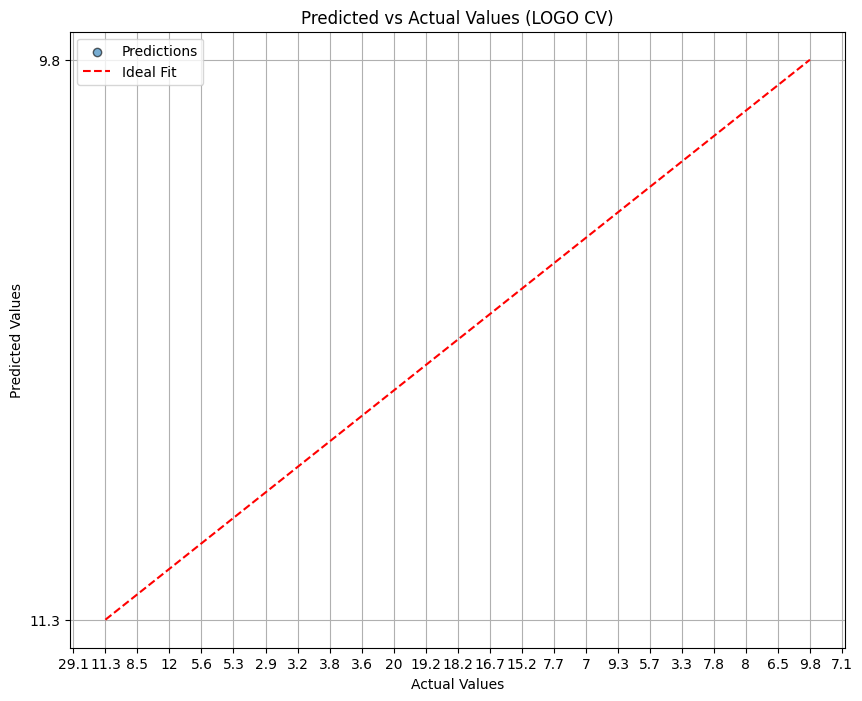

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
import innvestigate

def load_cleaned_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Loaded data from {filepath} with shape {df.shape}")
    # Remove rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]
    return df

# Specify your target columns (already defined)
target_columns = [
    "Digester", "Source", "Type", "Waste", "Biomass", 
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km",
    "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks"
]

df = load_cleaned_data('Data/df_1.csv')

# Split the DataFrame into features (X) and targets (y)
X = df.drop(columns=target_columns)  # OTU/ASV features
y = df[target_columns]




# -------------------------------------------------------------
# DEFINE CNN MODEL FUNCTION
# -------------------------------------------------------------
def build_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mse')
    return model

# -------------------------------------------------------------
# PREPROCESSING
# -------------------------------------------------------------
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)  # Convert to numpy array after scaling

# Define groups (digester groups)
groups = y['Digester']  # Assuming 'Digester' is the column with group info

# Define target column
target_column = 'ACE-km'

# Add a parameter for the number of features to select after LRP
num_features_after_lrp = 100  # Adjust as needed

# -------------------------------------------------------------
# LOGO CV SETUP
# -------------------------------------------------------------
logo = LeaveOneGroupOut()

lrp_cache = pd.DataFrame()
ann_predictions = np.array([])
ann_actuals = np.array([])

for fold, (train_idx, val_idx) in enumerate(logo.split(X_scaled, y[target_column], groups)):
    print(f"Processing Fold {fold + 1}")

    # Split data into training and validation sets
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx][target_column], y.iloc[val_idx][target_column]

    # Reshape data for neural network input
    X_train = np.expand_dims(X_train, axis=2)  # Shape: (samples, features, 1)
    X_val = np.expand_dims(X_val, axis=2)      # Shape: (samples, features, 1)

    # Build and train the neural network model
    model = build_cnn_model((X_train.shape[1], 1))  # Input shape: (features, 1)
    model.fit(X_train, y_train, batch_size=32, epochs=150, verbose=0, validation_data=(X_val, y_val))

    # Apply LRP
    analyzer = innvestigate.create_analyzer("lrp.z_plus_fast", model)
    relevance_scores = analyzer.analyze(X_train)  # Analyze training data

    # Flatten relevance scores
    relevance_scores_flat = relevance_scores.mean(axis=0).flatten()

    # Store LRP results for original features only
    lrp = pd.DataFrame(relevance_scores_flat, index=X.columns, columns=[f"Fold_{fold}"])
    lrp_cache = pd.concat([lrp_cache, lrp], axis=1)

    # Predict and store validation results
    predictions = model.predict(X_val).flatten()
    ann_predictions = np.concatenate([ann_predictions, predictions])
    ann_actuals = np.concatenate([ann_actuals, y_val])  # Store actual values for plotting

# -------------------------------------------------------------
# EVALUATE MODEL PERFORMANCE
# -------------------------------------------------------------
ann_r2 = r2_score(ann_actuals, ann_predictions)  # R² for regression
ann_mse = mean_squared_error(ann_actuals, ann_predictions)  # MSE for regression

print("\nCross Validation Results:\n")
print("Neural Network R2 Score: {:.5f}".format(ann_r2))
print("Mean Squared Error: {:.5f}".format(ann_mse))

# -------------------------------------------------------------
# SELECT TOP FEATURES BASED ON LRP
# -------------------------------------------------------------
lrp_cache["Mean_Abs_Relevance"] = lrp_cache.abs().mean(axis=1)
lrp_cache = lrp_cache.sort_values("Mean_Abs_Relevance", ascending=False)

print("\nTop 10 Features by Relevance:")
print(lrp_cache.head(10))

# Select top `num_features_after_lrp` features
selected_features = lrp_cache.head(num_features_after_lrp).index
X_selected = X[selected_features]  # Select only the top features

print(f"\nSelected {num_features_after_lrp} features based on LRP.")

# Save LRP results
lrp_cache.to_csv("lrp_feature_relevance.csv")

# -------------------------------------------------------------
# PLOT PREDICTED VS ACTUAL VALUES
# -------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(ann_actuals, ann_predictions, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([ann_actuals.min(), ann_actuals.max()],
         [ann_actuals.min(), ann_actuals.max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (LOGO CV)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.savefig("predicted_vs_actual_plot_logo.png")
plt.show()
